## 3.0 PPO + Transformer-Based Policy Network

To incorporate temporal context into PPO, we replace the MLP policy with a Transformer policy.  
Instead of conditioning only on the current state, the agent receives a short history of experience and attends to relevant past transitions.

---

### Sequential Input Representation

At timestep \(t\), we construct a window of recent experience:

$$
\mathcal{E}_t = \big[(s_{t-T+1}, a_{t-T+1}), \dots, (s_{t-1},a_{t-1}), (s_t,a_t)\big]
$$

Each element is embedded using a small MLP:

$$
x_i = \mathrm{MLP}_{\text{embed}}([s_i, a_i])
$$

---

### Temporal Positional Encoding

Because self-attention is order-invariant, we inject temporal indices using sinusoidal encodings:

$$
PE(i) = [\sin(\omega_k i), \cos(\omega_k i)]_{k=1}^{F}
$$

The input token for the Transformer becomes:

$$
z_i = x_i \;\Vert\; PE(i)
$$

---

### Transformer Encoder Block

A Transformer layer processes the sequence by attending over past and recent experience:

$$
H^{(l+1)} = \mathrm{LN}\Big(H^{(l)} +
\mathrm{MHA}(H^{(l)}, H^{(l)}, H^{(l)})\Big)
$$

$$
H^{(l+1)} = \mathrm{LN}\Big(H^{(l)} + \mathrm{FFN}(H^{(l)})\Big)
$$

The final hidden state \(H_T\) serves as a context summary for decision-making.

---

### Policy & Value Outputs

$$
\pi_\theta(a_t|\mathcal{E}_t) =
\mathrm{Softmax}(\mathrm{MLP}_{\text{policy}}(H_T))
$$

$$
V_\phi(\mathcal{E}_t) =
\mathrm{MLP}_{\text{value}}(H_T)
$$

This allows PPO to act based on *recent experience*, not just a single observation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

import gymnasium as gym
from gymnasium import spaces

import ray
from ray.rllib.algorithms.ppo import PPOConfig



In [2]:
def positional_encoding_3d(pos, num_freqs=4, max_freq=10.0):
    """
    pos: np.array shape (3,) with (x, y, z) in [-space_size, space_size].
    Returns: encoding vector of shape (3 * 2 * num_freqs,)
    """
    pos = np.asarray(pos, dtype=np.float32)
    assert pos.shape == (3,)

    freqs = np.linspace(1.0, max_freq, num_freqs)
    enc = []
    for coord in pos:            # x, y, z
        for f in freqs:
            enc.append(np.sin(f * coord))
            enc.append(np.cos(f * coord))
    return np.array(enc, dtype=np.float32)


class FrogFly3DEnv(gym.Env):
    """
    3D continuous environment:
    - Frog (agent) moves to catch a moving fly.
    - Observations: positions + relative vector + positional encodings.
    """
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, config=None):
        super().__init__()

        if config is None:
            config = {}

        self.space_size = float(config.get("space_size", 1.0))
        self.step_size = float(config.get("step_size", 0.1))
        self.fly_speed = float(config.get("fly_speed", 0.05))
        self.catch_radius = float(config.get("catch_radius", 0.15))
        self.max_steps = int(config.get("max_steps", 200))
        self.num_freqs = int(config.get("num_freqs", 4))
        self.use_positional_encodings = bool(
            config.get("use_positional_encodings", True)
        )

        # Action = 3D movement in [-1, 1]^3
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(3,), dtype=np.float32
        )

        # Observation components
        # frog_pos (3) + fly_pos (3) + rel (3) = 9
        base_dim = 9
        if self.use_positional_encodings:
            pe_dim = 3 * 2 * self.num_freqs  # per position
            obs_dim = base_dim + 2 * pe_dim
        else:
            obs_dim = base_dim

        self.observation_space = spaces.Box(
            low=-5.0, high=5.0, shape=(obs_dim,), dtype=np.float32
        )

        self.frog_pos = None
        self.fly_pos = None
        self.steps = 0
        self._value_out = None

    # ---------- Helpers ----------

    def _sample_position(self):
        return np.random.uniform(
            low=-self.space_size,
            high=self.space_size,
            size=(3,),
        ).astype(np.float32)

    def _clip_position(self, pos):
        return np.clip(pos, -self.space_size, self.space_size).astype(np.float32)

    def _get_obs(self):
        rel = self.fly_pos - self.frog_pos
        parts = [self.frog_pos, self.fly_pos, rel]

        if self.use_positional_encodings:
            frog_pe = positional_encoding_3d(self.frog_pos, self.num_freqs)
            fly_pe = positional_encoding_3d(self.fly_pos, self.num_freqs)
            parts.extend([frog_pe, fly_pe])

        return np.concatenate(parts, axis=0).astype(np.float32)

    def _get_distance(self):
        return float(np.linalg.norm(self.fly_pos - self.frog_pos))

    # ---------- Gymnasium API ----------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        self.frog_pos = self._sample_position()
        self.fly_pos = self._sample_position()

        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        self.steps += 1

        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, -1.0, 1.0)

        # Frog moves
        self.frog_pos = self.frog_pos + self.step_size * action
        self.frog_pos = self._clip_position(self.frog_pos)

        # Fly moves randomly
        fly_dir = np.random.normal(size=(3,)).astype(np.float32)
        fly_dir /= np.linalg.norm(fly_dir) + 1e-8
        self.fly_pos = self.fly_pos + self.fly_speed * fly_dir
        self.fly_pos = self._clip_position(self.fly_pos)

        dist = self._get_distance()
        caught = dist < self.catch_radius

        # Reward shaping: closer is better + bonus for catch
        reward = -dist
        if caught:
            reward += 10.0

        terminated = caught
        truncated = self.steps >= self.max_steps

        obs = self._get_obs()
        info = {"distance": dist, "caught": caught}

        return obs, reward, terminated, truncated, info

    def render(self):
        print(
            f"Step {self.steps} | "
            f"Frog: {self.frog_pos} | Fly: {self.fly_pos} | "
            f"Dist: {self._get_distance():.3f}"
        )

    def close(self):
        pass

In [3]:
from ray.tune.registry import register_env

# K-step observation history wrapper (if you don't already have this)
class ObsHistoryWrapper(gym.Wrapper):
    def __init__(self, env, K=8):
        super().__init__(env)
        self.K = K
        obs_shape = env.observation_space.shape  # (D,)
        self.history = np.zeros((K,) + obs_shape, dtype=np.float32)

        low  = np.repeat(env.observation_space.low[None, :],  K, axis=0)
        high = np.repeat(env.observation_space.high[None, :], K, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.history[:] = obs
        return self.history.copy(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.history = np.roll(self.history, shift=-1, axis=0)
        self.history[-1] = obs
        return self.history.copy(), reward, terminated, truncated, info

# Factory for RLlib
def make_frog_hist_env(env_config):
    base_env = FrogFly3DEnv(env_config)
    return ObsHistoryWrapper(base_env, K=8)

# Register under a name RLlib understands
register_env("frog_hist_env", make_frog_hist_env)



In [4]:
import numpy as np
import torch
import torch.nn as nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models import ModelCatalog

ray.shutdown()
ray.init(ignore_reinit_error=True)

class FrogTransformerModel(TorchModelV2, nn.Module):
    def __init__(
        self,
        obs_space,
        action_space,
        num_outputs,
        model_config,
        name,
        **kwargs,
    ):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        # Expect obs shape = (K, obs_dim_single)
        assert len(obs_space.shape) == 2, f"Expected (K, D), got {obs_space.shape}"
        self.seq_len    = obs_space.shape[0]  # K (time)
        self.feature_dim = obs_space.shape[1] # D (per-timestep features)

        cmc = model_config.get("custom_model_config", {}) or {}

        def get_hp(key, default):
            return kwargs.get(key, cmc.get(key, default))

        d_model    = get_hp("d_model", 64)
        nhead      = get_hp("nhead", 4)
        num_layers = get_hp("num_layers", 1)
        dim_ff     = get_hp("dim_feedforward", 128)
        dropout    = get_hp("dropout", 0.1)

        # Embedding per timestep (map R^{D} -> R^{d_model})
        self.embed = nn.Linear(self.feature_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="relu",
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        self.policy_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_outputs),
        )
        self.value_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1),
        )

        self._features = None

    def forward(self, input_dict, state, seq_lens):
        # Get obs as float tensor, whatever its shape is
        x = input_dict["obs"].float()       # shape: (B, ...) with possibly >2 dims
        B = x.shape[0]

        # Flatten all non-batch dims into a single feature dimension
        x = x.view(B, -1)                   # shape: (B, F_flat)
        F = x.shape[1]

        # --- Infer how to interpret the obs as (B, K, D) sequence ---
        # Case 1: env gives a single feature vector of length feature_dim → treat as K=1
        if F == self.feature_dim:
            K = 1
        # Case 2: env gives a flattened sequence of length seq_len * feature_dim
        elif F == self.seq_len * self.feature_dim:
            K = self.seq_len
        else:
            raise RuntimeError(
                f"Cannot reshape obs of size {F} into "
                f"(B, K, feature_dim={self.feature_dim}) with seq_len={self.seq_len}."
            )

        # Reshape to (B, K, D)
        x = x.view(B, K, self.feature_dim)

        # --- Standard Transformer forward ---
        # (B, K, D) → (B, K, d_model)
        x = self.embed(x)

        # Optional: positional encodings, if you defined self.pos_embed
        if hasattr(self, "pos_embed"):
            # assume pos_embed has shape (1, max_K, d_model)
            x = x + self.pos_embed[:, :K, :]

        # TransformerEncoder expects (K, B, d_model)
        x = x.transpose(0, 1)          # (K, B, d_model)
        x = self.transformer(x)        # (K, B, d_model)
        x = x.transpose(0, 1)          # (B, K, d_model)

        # Pooling: take last token
        token = x[:, -1, :]            # (B, d_model)

        # Policy and value heads
        logits = self.policy_head(token)     # (B, num_actions)
        value  = self.value_head(token)      # (B, 1)

        # RLlib expects value via this attribute
        self._value_out = value.squeeze(-1)  # (B,)

        # Return logits + empty RNN state list
        return logits, []

    def value_function(self):
        # RLlib calls this after forward() to get V(s).
        if self._value_out is None:
            raise ValueError("value_function() called before forward().")
        return self._value_out




ModelCatalog.register_custom_model("frog_transformer_policy", FrogTransformerModel)




2025-12-02 02:22:30,652	INFO worker.py:2023 -- Started a local Ray instance.
/home/platinumfish/miniconda3/envs/rl-project/lib/python3.10/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [5]:
def make_frog_env(env_config):
    base_env = FrogFly3DEnv(env_config)
    return ObsHistoryWrapper(base_env, K=8)  # e.g., last 8 obs

In [6]:
from ray.rllib.algorithms.ppo import PPOConfig

env_config = {
    "space_size": 1.0,
    "step_size": 0.1,
    "fly_speed": 0.05,
    "catch_radius": 0.15,
    "max_steps": 200,
    "num_freqs": 4,
    "use_positional_encodings": True,
}

config = (
    PPOConfig()
    .environment(
        env="frog_hist_env",    # registered history-wrapped env
        env_config=env_config,
    )
    .framework("torch")
    .api_stack(
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False,
    )
    .env_runners(
        num_env_runners=1,
        num_envs_per_env_runner=4,
        create_env_on_local_worker=True,
    )
    .resources(num_gpus=0)
    .training(
        model={
            "custom_model": "frog_transformer_policy",
            "custom_model_config": {
                "d_model": 64,
                "nhead": 4,
                "num_layers": 1,
                "dim_feedforward": 128,
                "dropout": 0.1,
                "entropy_coeff": 0.01
            },
        },
        gamma=0.99,
        lr=1e-4,          # a bit conservative to help with stability
        grad_clip=0.5,    # gradient clipping threshold
        grad_clip_by="global_norm",  # (this is the default but being explicit)
        train_batch_size=2000,
        num_epochs=10,
        minibatch_size=256,
        clip_param=0.2,
    )
    .evaluation(
        evaluation_duration=20,              # 20 eval episodes instead of 10
        evaluation_duration_unit="episodes", # interpret that as episodes
        # optional, but good practice:
        evaluation_config={
            "explore": False,               # greedy eval
        },
    ) 
)

algo = config.build()
print("Algo built OK with grad clipping")






2025-12-02 02:22:32,094	WARNING 3989743005.py:61 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
/home/platinumfish/miniconda3/envs/rl-project/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/platinumfish/miniconda3/envs/rl-project/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed i

Algo built OK with grad clipping


In [7]:
res = algo.train()
print(res.keys())
print(res)


2025-12-02 02:22:41,618	WARNING train_ops.py:114 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


dict_keys(['custom_metrics', 'episode_media', 'info', 'env_runners', 'num_healthy_workers', 'actor_manager_num_outstanding_async_reqs', 'num_remote_worker_restarts', 'num_agent_steps_sampled', 'num_agent_steps_trained', 'num_env_steps_sampled', 'num_env_steps_trained', 'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter', 'num_env_steps_sampled_throughput_per_sec', 'num_env_steps_trained_throughput_per_sec', 'timesteps_total', 'num_env_steps_sampled_lifetime', 'num_agent_steps_sampled_lifetime', 'num_steps_trained_this_iter', 'agent_timesteps_total', 'timers', 'counters', 'done', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'perf'])
{'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float64(0.5), 'cur_kl_coeff': np.float64(0.1999999

In [8]:
for i in range(10):
    result = algo.train()

    er = result["env_runners"]  # shorthand

    reward_mean = er["episode_return_mean"]
    len_mean    = er["episode_len_mean"]

    print(
        f"Iter {i+1}: "
        f"reward_mean={float(reward_mean):.2f}, "
        f"len_mean={float(len_mean):.1f}"
    )




Iter 1: reward_mean=-280.23, len_mean=183.9
Iter 2: reward_mean=-298.76, len_mean=189.3


(pid=gcs_server) [2025-12-02 02:22:59,547 E 2248215 2248215] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-02 02:23:00,613 E 2248330 2248330] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(RolloutWorker pid=2248382) [2025-12-02 02:23:01,699 E 2248382 2248495] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-02 02:23:02,043 E 2245261 2248375] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent.

Iter 3: reward_mean=-297.60, len_mean=192.0
Iter 4: reward_mean=-278.83, len_mean=188.0
Iter 5: reward_mean=-274.44, len_mean=188.1
Iter 6: reward_mean=-275.81, len_mean=189.9
Iter 7: reward_mean=-268.98, len_mean=187.6
Iter 8: reward_mean=-270.79, len_mean=188.9
Iter 9: reward_mean=-272.26, len_mean=191.3
Iter 10: reward_mean=-267.32, len_mean=192.2


In [9]:
def get_train_metrics(result):
    """Extract mean reward and len from an RLlib result dict (env_runners layout)."""
    er = result.get("env_runners", {})
    reward_mean = float(er.get("episode_return_mean", float("nan")))
    len_mean    = float(er.get("episode_len_mean", float("nan")))
    return reward_mean, len_mean


In [10]:
import numpy as np

eval_env = FrogFly3DEnv(env_config)  # reuse your env_config


def evaluate_policy(algo, env, num_episodes=5, render=False):
    """
    Evaluate a single-agent policy using the legacy RLlib API.

    Uses algo.compute_single_action(obs, ...) which is the right call
    for this RLlib version (compute_actions is multi-agent only here).
    """
    returns = []
    lengths = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        ep_ret = 0.0
        steps = 0

        while not done:
            # Single-agent action: returns (action, state_out, info)
            action, _, _ = algo.compute_single_action(obs, explore=False)

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            ep_ret += reward
            steps += 1

            if render:
                env.render()

        returns.append(ep_ret)
        lengths.append(steps)

    return {
        "mean_return": float(np.mean(returns)),
        "std_return": float(np.std(returns)),
        "mean_length": float(np.mean(lengths)),
    }



In [11]:
import os

num_iterations = 200        # how long you want to train
eval_interval  = 10         # how often to run eval
eval_episodes  = 5

train_history = []          # for plotting later
best_eval_return = -float("inf")
checkpoint_dir = "frog_transformer_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for i in range(1, num_iterations + 1):
    # ---- 1. One PPO training iteration ----
    result = algo.train()
    train_reward, train_len = get_train_metrics(result)

    # ---- 2. Periodic evaluation ----
    if i % eval_interval == 0:
        eval_stats = evaluate_policy(
            algo,
            eval_env,
            num_episodes=eval_episodes,
            render=False,
        )
        eval_return = eval_stats["mean_return"]
        eval_len    = eval_stats["mean_length"]

        print(
            f"[Iter {i:4d}] "
            f"train_reward={train_reward:8.2f}, "
            f"train_len={train_len:6.1f} | "
            f"eval_return={eval_return:8.2f}, "
            f"eval_len={eval_len:6.1f}"
        )

        # Save history for plotting
        train_history.append(
            {
                "iter": i,
                "train_reward": train_reward,
                "train_len": train_len,
                "eval_return": eval_return,
                "eval_len": eval_len,
            }
        )

        # save best checkpoint
        if eval_return > best_eval_return:
            best_eval_return = eval_return
            checkpoint_path = algo.save(checkpoint_dir)
            print(f"  New best eval_return={best_eval_return:.2f}, saved to {checkpoint_path}")
    else:
        # Lighter log on non-eval iterations
        print(
            f"[Iter {i:4d}] "
            f"train_reward={train_reward:8.2f}, "
            f"train_len={train_len:6.1f}"
        )



[Iter    1] train_reward= -260.40, train_len= 190.9
[Iter    2] train_reward= -255.53, train_len= 189.5
[Iter    3] train_reward= -256.08, train_len= 188.1
[Iter    4] train_reward= -256.83, train_len= 188.5
[Iter    5] train_reward= -257.20, train_len= 188.7
[Iter    6] train_reward= -262.91, train_len= 190.2
[Iter    7] train_reward= -261.13, train_len= 190.3
[Iter    8] train_reward= -261.91, train_len= 188.8
[Iter    9] train_reward= -259.03, train_len= 188.5


2025-12-02 02:24:49,971	WARNING 1093147107.py:24 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


[Iter   10] train_reward= -254.61, train_len= 188.5 | eval_return= -237.28, eval_len= 200.0
  New best eval_return=-237.28, saved to TrainingResult(checkpoint=Checkpoint(filesystem=local, path=frog_transformer_checkpoints), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float64(0.5), 'cur_kl_coeff': np.float64(0.3000000000000001), 'cur_lr': np.float64(0.00010000000000000005), 'total_loss': np.float64(9.4270535332816), 'policy_loss': np.float64(0.03399819646562849), 'vf_loss': np.float64(9.390232310976302), 'vf_explained_var': np.float64(-0.005456646851130894), 'kl': np.float64(0.009410177204491837), 'entropy': np.float64(5.0055889129638675), 'entropy_coeff': np.float64(0.0)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(256.0), 'num_grad_updates_lifetime': np.float64(1435.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(34.5)}}, 'num

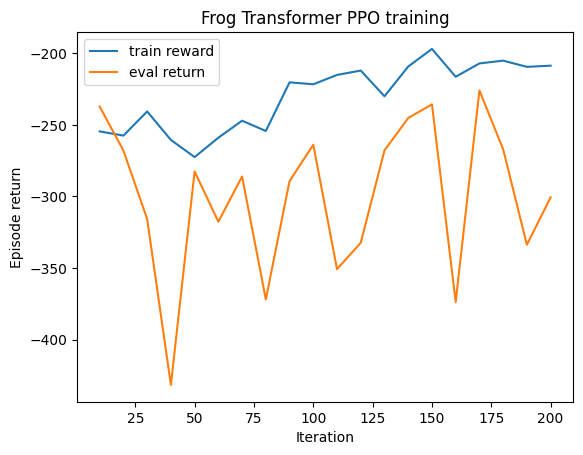

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df_hist = pd.DataFrame(train_history)

plt.figure()
plt.plot(df_hist["iter"], df_hist["train_reward"], label="train reward")
plt.plot(df_hist["iter"], df_hist["eval_return"], label="eval return")
plt.xlabel("Iteration")
plt.ylabel("Episode return")
plt.legend()
plt.title("Frog Transformer PPO training")
plt.show()



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import imageio

# ------------------------------------------------------------
# 1. UNWRAP ENV (in case it's inside ObsHistoryWrapper)
# ------------------------------------------------------------
def unwrap_env(env):
    """Return underlying FrogFly3DEnv even if wrapped."""
    while hasattr(env, "env"):
        env = env.env
    return env

# ------------------------------------------------------------
# 2. ROLLOUT AND RECORD POSITIONS
# ------------------------------------------------------------
def rollout_trajectory(env, algo, max_steps=200):
    raw_env = unwrap_env(env)

    obs, info = env.reset()

    frog_traj = [raw_env.frog_pos.copy()]
    fly_traj  = [raw_env.fly_pos.copy()]

    for _ in range(max_steps):
        action, _, _ = algo.compute_single_action(obs, explore=False)
        obs, reward, terminated, truncated, info = env.step(action)

        frog_traj.append(raw_env.frog_pos.copy())
        fly_traj.append(raw_env.fly_pos.copy())

        if terminated or truncated:
            break

    return np.array(frog_traj), np.array(fly_traj)

# ------------------------------------------------------------
# 3. CREATE 3D ANIMATION
# ------------------------------------------------------------
def make_3d_gif(frog_traj, fly_traj, gif_path="transformer_original_3d.gif"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # initial points
    frog_dot, = ax.plot([], [], [], 'go', markersize=8)
    fly_dot,  = ax.plot([], [], [], 'ro', markersize=8)

    # history lines
    frog_path, = ax.plot([], [], [], 'g-', linewidth=2, alpha=0.7)
    fly_path,  = ax.plot([], [], [], 'r-', linewidth=2, alpha=0.7)

    # axis limits
    ax.set_xlim([-1.0, 1.0])
    ax.set_ylim([-1.0, 1.0])
    ax.set_zlim([-1.0, 1.0])
    ax.set_title("Frog-Fly 3D Trajectory (Original Transformer PPO)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    def init():
        frog_dot.set_data([], [])
        frog_dot.set_3d_properties([])
        fly_dot.set_data([], [])
        fly_dot.set_3d_properties([])
        frog_path.set_data([], [])
        frog_path.set_3d_properties([])
        fly_path.set_data([], [])
        fly_path.set_3d_properties([])
        return frog_dot, fly_dot, frog_path, fly_path

    def update(i):
        # --- frog point ---
        frog_dot.set_data([frog_traj[i, 0]], [frog_traj[i, 1]])
        frog_dot.set_3d_properties([frog_traj[i, 2]])

        # --- fly point ---
        fly_dot.set_data([fly_traj[i, 0]], [fly_traj[i, 1]])
        fly_dot.set_3d_properties([fly_traj[i, 2]])

        # --- frog path ---
        frog_path.set_data(frog_traj[:i+1, 0], frog_traj[:i+1, 1])
        frog_path.set_3d_properties(frog_traj[:i+1, 2])

        # --- fly path ---
        fly_path.set_data(fly_traj[:i+1, 0], fly_traj[:i+1, 1])
        fly_path.set_3d_properties(fly_traj[:i+1, 2])

        return frog_dot, fly_dot, frog_path, fly_path

    ani = animation.FuncAnimation(
        fig, update, init_func=init,
        frames=len(frog_traj),
        interval=60,
        blit=False  # IMPORTANT for 3D
    )

    ani.save(gif_path, writer="pillow", fps=20)

    plt.close(fig)
    print(f"Saved 3D GIF to: {gif_path}")

# ------------------------------------------------------------
# 4. RUN IT
# ------------------------------------------------------------

# STEP A — create a fresh evaluation env (unwrapped)
eval_env = FrogFly3DEnv(env_config)

# STEP B — rollout using the trained algorithm "algo"
frog_traj, fly_traj = rollout_trajectory(eval_env, algo)

# STEP C — render the GIF
make_3d_gif(frog_traj, fly_traj, gif_path="transformer_original_3d.gif")


Saved 3D GIF to: transformer_original_3d.gif


(raylet) [2025-12-02 15:59:31,681 E 2248330 2248330] (raylet) node_manager.cc:3277: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 4f5df2e60efa7da9b72e6572929ecde932b3c32d83c84c30aeafac70, IP: 192.168.86.52) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.86.52`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
